In [ ]:
import cv2
import numpy as np
from numpy.linalg import svd, inv

%matplotlib notebook
from matplotlib import pyplot as plt

In [ ]:
# images location
i_r = './rgb11.jpg'   # real image 
i_t = './th11.png'   # thermal image

# Load an color image  
img_r = cv2.imread(i_r)
img_t = cv2.imread(i_t)

<IPython.core.display.Javascript object>


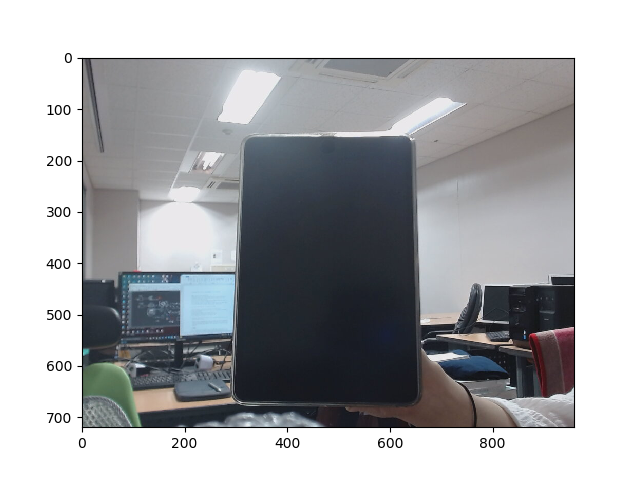

In [ ]:
# 사진위에 마우스를 올리면 x, y 좌표값과 컬러값을 알수 있음 
# 이를 통해 얼굴을 cover 하는 bounding box 좌표를 알아냄 

plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))

<IPython.core.display.Javascript object>


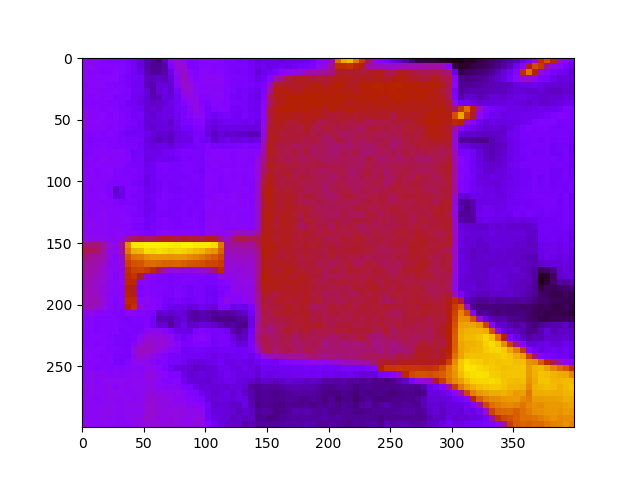

In [ ]:
# 같은 방법으로 얼굴 bounding box 좌표를 알아냄 

plt.imshow(cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))

In [ ]:
#  사진 1의 점들을 사진2의 점들로 옮기기 위한 H 를 계산함 

def computeHomography(pts1, pts2, normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''       
    assert pts1.shape == pts2.shape
    
    plen = pts1.shape[1]
    a = np.zeros((plen * 2, 9))
    
    for i in range(0, plen): 
        a[i * 2, 0 : 3] = - pts1[:, i].reshape(1, 3)
        a[i * 2, 6 : 9] = pts1[:, i].reshape(1, 3) * pts2[0, i]
        a[i * 2 + 1, 3 : 6] = - pts1[:, i].reshape(1, 3)
        a[i * 2 + 1, 6 : 9] = pts1[:, i].reshape(1, 3) * pts2[1, i]
    
    u, s, vh = svd(a)
    h = vh[vh.shape[0]-1, :]

    H = np.array(h.reshape(3, 3))
    H = H / H[2, 2]
    
    return H 

In [ ]:
# pts_r : Real Image 영상의 얼굴 Bounding Box 좌표 값 (x, y, 1) 
# pts_t : Thermal Image 영상의 얼굴 Bounding Box 좌표값 (x, y, 1)

pts_r = np.array([[321, 161, 1] , [639, 156, 1] , [656, 664, 1], [296, 658, 1]]).T
pts_t = np.array([[153, 17, 1] , [299, 9, 1] , [298, 246, 1], [140, 240, 1]]).T

print(pts_r.shape)

(3, 4)


In [ ]:
#  Calculate Homography to project Thermal image to Real Image  
# Thermal 이미지 -> Real Image 로 바꾸기 (순서 조심, 목적에 따라 반대로 적용해야 할 수도 있음 ) 

H = computeHomography(pts_t, pts_r)
print(H)

[[ 2.43629833e+00 -3.30855957e-02 -3.90352938e+01]
 [ 1.27797578e-01  2.18992834e+00  1.10315071e+02]
 [ 2.67830566e-04 -1.82896517e-04  1.00000000e+00]]


<IPython.core.display.Javascript object>


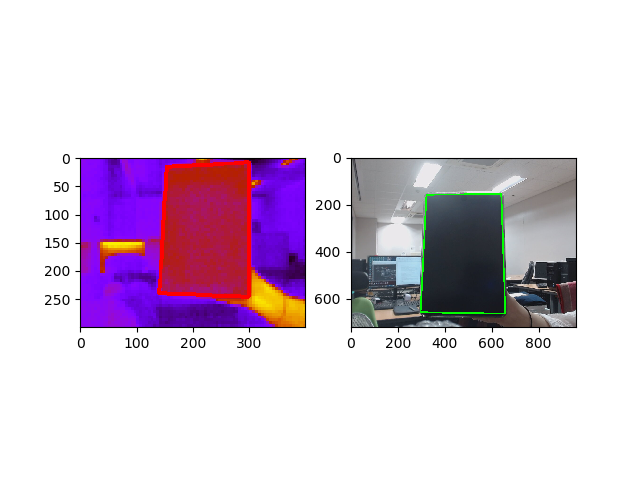

In [ ]:
# Mapping Test 
# Bounding Box 가 잘 Projection 되었는지 그림으로 그려서 확인하는 과정 


testPts = pts_t
destPts = np.dot(H, testPts)
destPts[0, :] = destPts[0, :] / destPts[2, :]
destPts[1, :] = destPts[1, :] / destPts[2, :]
destPts = destPts.astype('int32')

# Draw lines 
red = (255, 0, 0)
green = (0, 255, 0)

# 열화상 이미지에 라인을 그림 
im1_test = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
cv2.line(im1_test, tuple(testPts[:2, 0]), tuple(testPts[:2, 1]), red, 5)
cv2.line(im1_test, tuple(testPts[:2, 1]), tuple(testPts[:2, 2]), red, 5)
cv2.line(im1_test, tuple(testPts[:2, 2]), tuple(testPts[:2, 3]), red, 5)
cv2.line(im1_test, tuple(testPts[:2, 3]), tuple(testPts[:2, 0]), red, 5)

# Real 이미지에 라인을 그림 
im2_test = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)
cv2.line(im2_test, tuple(destPts[:2, 0]), tuple(destPts[:2, 1]), green, 5)
cv2.line(im2_test, tuple(destPts[:2, 1]), tuple(destPts[:2, 2]), green, 5)
cv2.line(im2_test, tuple(destPts[:2, 2]), tuple(destPts[:2, 3]), green, 5)
cv2.line(im2_test, tuple(destPts[:2, 3]), tuple(destPts[:2, 0]), green, 5)

# 2열로 그림을 붙임 
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1_test)
axes[1].imshow(im2_test)

<IPython.core.display.Javascript object>


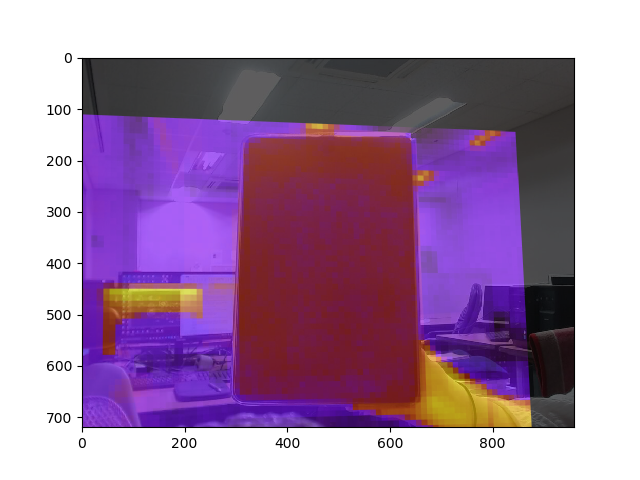

In [ ]:
# Thermal mage projection 
# 이미지 전체를 cv2.warpPerspective 함수를 사용해서 Projection 함 
# 그뒤에 두 이미지를 blending 해서 잘 projection 되었는지 시각화 


projectedWidth = img_r.shape[1]
projectedHeight = img_r.shape[0]

xtrans = 0
ytrans = 0

transAff = np.identity(3)
transAff[0, 2] = xtrans
transAff[1, 2] = ytrans

sourceHomography = np.dot(transAff, H)
refHomography = np.dot(transAff, np.identity(3))


projected_thermal = cv2.warpPerspective(img_t, H, (projectedWidth, projectedHeight))

a = 0.4
blended = cv2.addWeighted(img_r, a, projected_thermal, 1-a, 0)


plt.figure()
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))

In [ ]:
# 그림 2 로 같은 연산 수행 

In [ ]:
# images location
i_r = './2_r.jpg'   # real image 
i_t = './2_t.jpg'   # thermal image

# Load an color image 
img_r = cv2.imread(i_r)
img_t = cv2.imread(i_t)

In [ ]:
plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))

In [ ]:
pts_r = np.array([[874, 64, 1] , [1218, 64, 1] , [1218, 579, 1], [874, 579, 1]]).T
pts_t = np.array([[140, 28, 1] , [237, 28, 1] , [237, 170, 1], [140, 170, 1]]).T

print(pts_r.shape)

In [ ]:
H = computeHomography(pts_t, pts_r)
print(H)

In [ ]:
# Mapping Test 

# Transform points 
testPts = pts_t
destPts = np.dot(H, testPts)
destPts[0, :] = destPts[0, :] / destPts[2, :]
destPts[1, :] = destPts[1, :] / destPts[2, :]
destPts = destPts.astype('int32')

# Draw lines 
red = (255, 0, 0)
green = (0, 255, 0)

# lines on Img1
im1_test = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
cv2.line(im1_test, tuple(testPts[:2, 0]), tuple(testPts[:2, 1]), red, 5)
cv2.line(im1_test, tuple(testPts[:2, 1]), tuple(testPts[:2, 2]), red, 5)
cv2.line(im1_test, tuple(testPts[:2, 2]), tuple(testPts[:2, 3]), red, 5)
cv2.line(im1_test, tuple(testPts[:2, 3]), tuple(testPts[:2, 0]), red, 5)

# lines on Img2
im2_test = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)
cv2.line(im2_test, tuple(destPts[:2, 0]), tuple(destPts[:2, 1]), green, 5)
cv2.line(im2_test, tuple(destPts[:2, 1]), tuple(destPts[:2, 2]), green, 5)
cv2.line(im2_test, tuple(destPts[:2, 2]), tuple(destPts[:2, 3]), green, 5)
cv2.line(im2_test, tuple(destPts[:2, 3]), tuple(destPts[:2, 0]), green, 5)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1_test)
axes[1].imshow(im2_test)

In [ ]:
# Thermal mage projection 

projectedWidth = img_r.shape[1]
projectedHeight = img_r.shape[0]

xtrans = 0
ytrans = 0

transAff = np.identity(3)
transAff[0, 2] = xtrans
transAff[1, 2] = ytrans

sourceHomography = np.dot(transAff, H)
refHomography = np.dot(transAff, np.identity(3))


projected_thermal = cv2.warpPerspective(img_t, H, (projectedWidth, projectedHeight))

a = 0.4
blended = cv2.addWeighted(img_r, a, projected_thermal, 1-a, 0)


plt.figure()
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))